In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# scikit-learn machine learning
# from sklearn.preprocessing import Normalizer, StandardScaler, normalize, scale
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-colorblind')

# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 
# %matplotlib notebook

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


# Are teachers from different schools paid the same?

Teacher salaries in Boston are well above the national average. High cost of living expenses and residency requirements mean that teacher pay might not go as far here as in other places. The question addressed here is whether teacher pay depends on the school where they teach, i.e. is there a difference in pay for elite vs underperforming schools or by neighborhood?

In 2017 the original "department" category lists each school as its own department. First we need to exclude school departments with few teachers in order for the statistical calculations to be significant. Substitute teachers and paraprofessionals will be added to the data.

In [3]:
# Return list of largest schools

schoolsize = earnings[(earnings.title_clean.isin(['Teacher', 'Substitute Teacher', 'Paraprofessional']))\
                   & (earnings.year == 2017)\
                   & (-earnings.department.isin(['BPS Substitute Teachers/Nurs', 'BPS Human Resource Team']))] \
                    .groupby('department')['name']\
                    .agg('count')
largeschools = schoolsize[schoolsize > 90].index  # minimum number of teachers

Teachers are generally not paid ***retro***, ***injured***, ***detail*** or ***quinn***, so we can focus on the ***regular***, ***overtime*** and ***other*** earnings categories. 

In [4]:
# using original school departments

schools = earnings[['name','regular', 'overtime', 'other', 'total', 'title_clean', 'department']]\
                    [(earnings.title_clean.isin(['Teacher', 'Substitute Teacher', 'Paraprofessional'])) \
                    & (earnings.department.isin(largeschools))\
                    & (earnings.year == 2017)]
X = schools.drop(['name', 'total', 'title_clean', 'department'], axis=1)
y = schools['department']
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

# Knn
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)

# metrics:
print('Score:', clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
cv_scores = cross_val_score(clf, X, y, cv=10)

print('mean cv score:', np.mean(cv_scores), '\n')
print(metrics.classification_report(y_test, y_pred))

(2056, 3)
Score: 0.15559157212317667
mean cv score: 0.12901643034476756 

                               precision    recall  f1-score   support

             BPS Boston Latin       0.16      0.34      0.22        35
         BPS Charlestown High       0.02      0.03      0.03        34
        BPS Condon Elementary       0.15      0.14      0.14        35
         BPS East Boston High       0.03      0.03      0.03        30
            BPS Latin Academy       0.06      0.09      0.07        23
           BPS Lee Elementary       0.16      0.11      0.13        46
        BPS Madison Park High       0.08      0.05      0.06        38
          BPS McKinley Middle       0.22      0.29      0.25        49
        BPS Murphy Elementary       0.05      0.05      0.05        22
          BPS O'Bryant School       0.07      0.04      0.05        23
BPS Orchard Gardens K-8 Pilot       0.04      0.05      0.04        22
        BPS Quincy Elementary       0.11      0.05      0.07        39
  

KNN classification can be applied on the ***regular***, ***overtime*** and ***other*** categories to determine if machine learning algorithms can detect differences in the earnings structure. The accuracy and f1-score for predicting a school with the KNN classifier is only ~14%. This result suggests there is no significant difference in mean regular earnings between schools. 

A proper statistical analysis would be perhaps more appropriate.

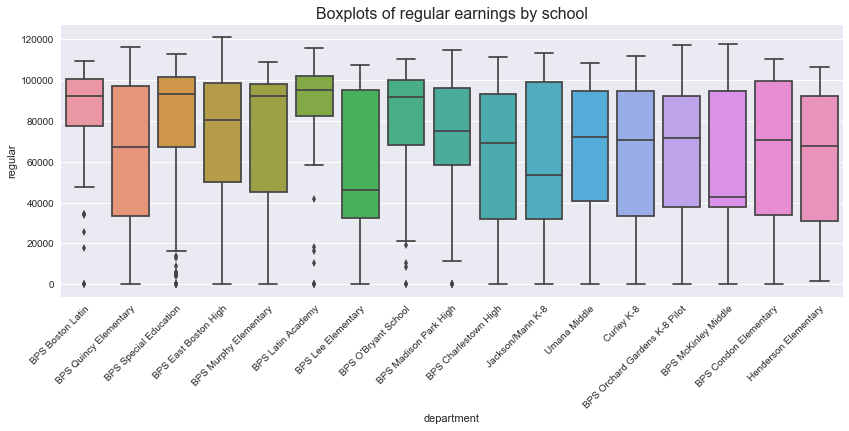

In [5]:
# Box plot:
fig, ax = plt.subplots(figsize=(14,5))
sns.boxplot(x='department', y='regular', data=schools, ax=ax)
ax.set_title('Boxplots of regular earnings by school', fontsize=16)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

The boxplots show high variance for regular earnings across select schools. A few schools have noticeably low variance:

* ***BPS Boston Latin***: Elite public preparatory school
* ***BPS Latin Academy***: Formerly girl's alternative to Boston Latin
* ***BPS O'Bryant School***: Math and Science magnet school
* ***BPS Madison Park High***: The only vocational school in Boston
* ***BPS Special Education***: A collection of special education teachers, therapists, speech pathologists etc. Often mistakenly given a "Teacher" title.

All of these schools have in common a specialty focus which would make them attractive for teachers with specific training. 

Variance in earnings data is a measure of turnover since the data doesn't capture annual salary or start and end dates. Low variance indicates either higher pay, making employees less likely to leave for better paying jobs, or a special job qualification, i.e. there are fewer jobs available elsewhere.

The schools will be split into two groups, based on variance. 

## ANOVA

Analysis of variance techniques are appropriate for determining differences between means of several groups. 

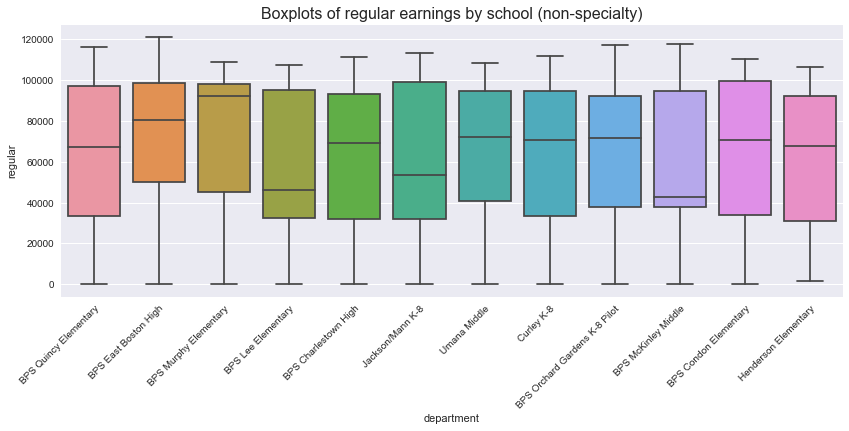

                  sum_sq      df         F    PR(>F)
department  3.204546e+10    11.0  2.753744  0.001555
Residual    1.400678e+12  1324.0       NaN       NaN
Effect size: 2.24% of the regular earnings variance is explained by the associated school.


group1,group2,meandiff,lower,upper,reject
BPS Charlestown High,BPS Condon Elementary,3747.849,-11022.1751,18517.8732,False
BPS Charlestown High,BPS East Boston High,9295.4976,-4939.1214,23530.1166,False
BPS Charlestown High,BPS Lee Elementary,-2879.9703,-17454.6945,11694.7539,False
BPS Charlestown High,BPS McKinley Middle,-4058.587,-17880.0244,9762.8504,False
BPS Charlestown High,BPS Murphy Elementary,13947.9062,-1363.3005,29259.113,False
BPS Charlestown High,BPS Orchard Gardens K-8 Pilot,2953.1201,-11995.111,17901.3511,False
BPS Charlestown High,BPS Quincy Elementary,-19.7135,-14625.6962,14586.2692,False
BPS Charlestown High,Curley K-8,1951.0158,-12336.1658,16238.1974,False
BPS Charlestown High,Henderson Elementary,-1542.2513,-15967.7753,12883.2727,False
BPS Charlestown High,Jackson/Mann K-8,-710.4463,-15514.9208,14094.0281,False


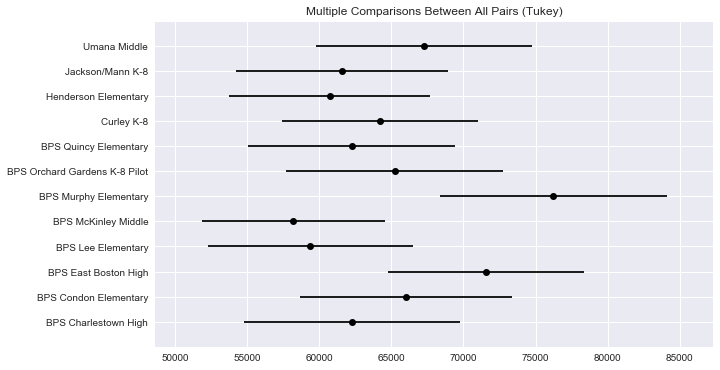

In [6]:
""" ANOVA analysis of regular earnings by non-specialty school"""

specialty_schools = ['BPS Boston Latin', 'BPS Latin Academy', 'BPS Madison Park High', 'BPS O\'Bryant School', 'BPS Special Education']
regular_schools = set(largeschools) - set(specialty_schools)

# Remove specialty schools:
schools_ref = schools[schools['department'].isin(regular_schools)]

# Box plot:
fig, ax = plt.subplots(figsize=(14,5))
sns.boxplot(x='department', y='regular', data=schools_ref, ax=ax)
ax.set_title('Boxplots of regular earnings by school (non-specialty)', fontsize=16)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

# OLS model:
model = ols('regular ~ department', data=schools_ref).fit()

# ANOVA:                
aov_table = anova_lm(model, typ=2)
print(aov_table)

# effect size
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print('Effect size: {:.2f}% of the regular earnings variance is explained by the associated school.'.format(esq_sm*100))

# Tukey's comparison:
tukey = pairwise_tukeyhsd(endog=schools_ref['regular'],     # Data
                          groups=schools_ref['department'],   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals

tukey.summary()              # See test summary

The ANOVA results show two schools that reject the null hypothesis (H0 = the means *are* different). A closer look at these schools show some interesting facts, courtesy of https://www.bostonpublicschools.org:

* ***BPS Murphy Elementary*** is a selective magnet school
* ***BPS McKinley Middle*** is a special school with focus on students with behavioral issues.

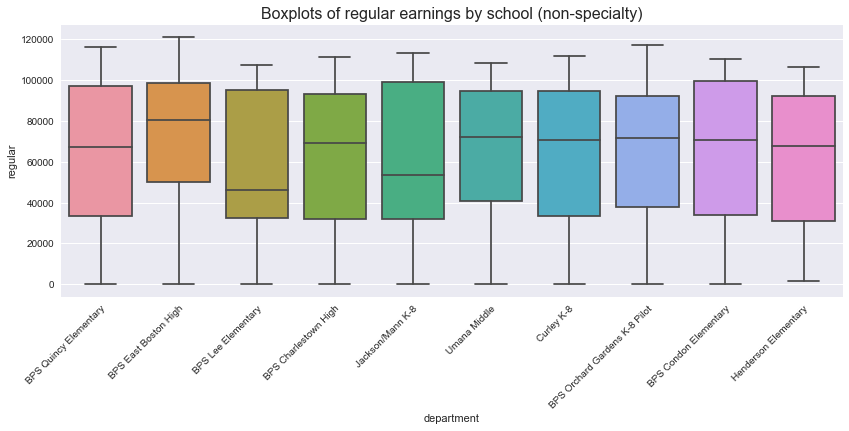

                  sum_sq      df         F   PR(>F)
department  1.367001e+10     9.0  1.417131  0.17565
Residual    1.170413e+12  1092.0       NaN      NaN
Effect size: 1.15% of the regular earnings variance is explained by the associated school.


group1,group2,meandiff,lower,upper,reject
BPS Charlestown High,BPS Condon Elementary,3747.849,-10647.9868,18143.6849,False
BPS Charlestown High,BPS East Boston High,9295.4976,-4578.4972,23169.4924,False
BPS Charlestown High,BPS Lee Elementary,-2879.9703,-17085.454,11325.5134,False
BPS Charlestown High,BPS Orchard Gardens K-8 Pilot,2953.1201,-11616.408,17522.6481,False
BPS Charlestown High,BPS Quincy Elementary,-19.7135,-14255.6638,14216.2368,False
BPS Charlestown High,Curley K-8,1951.0158,-11974.2099,15876.2416,False
BPS Charlestown High,Henderson Elementary,-1542.2513,-15602.3146,12517.812,False
BPS Charlestown High,Jackson/Mann K-8,-710.4463,-15139.8597,13718.967,False
BPS Charlestown High,Umana Middle,5001.2926,-9532.3055,19534.8908,False
BPS Condon Elementary,BPS East Boston High,5547.6485,-8181.9671,19277.2642,False


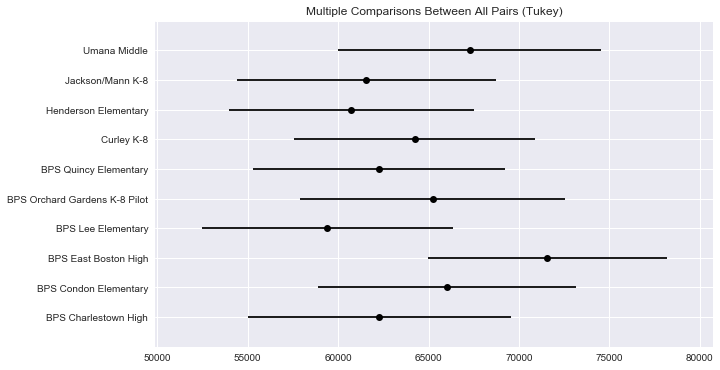

In [7]:
# Remove additional schools:
schools_ref = schools[(schools['department'].isin(regular_schools)) & (-schools['department'].isin(['BPS Murphy Elementary', 'BPS McKinley Middle']))]

# Box plot:
fig, ax = plt.subplots(figsize=(14,5))
sns.boxplot(x='department', y='regular', data=schools_ref, ax=ax)
ax.set_title('Boxplots of regular earnings by school (non-specialty)', fontsize=16)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

# OLS model:
model = ols('regular ~ department', data=schools_ref).fit()

# ANOVA:                
aov_table = anova_lm(model, typ=2)
print(aov_table)

# effect size
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print('Effect size: {:.2f}% of the regular earnings variance is explained by the associated school.'.format(esq_sm*100))

# Tukey's comparison:
tukey = pairwise_tukeyhsd(endog=schools_ref['regular'],     # Data
                          groups=schools_ref['department'],   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals

tukey.summary()              # See test summary

The null hypothesis of the ANOVA test states there is a significant difference between regular earnings means of teachers at different schools. This hypothesis must be rejected (p=0.17). For the 10 largest non-specialty schools in Boston, the ANOVA results imply that teacher income is independent of the school at which they teach. Just over 1% of the variance in total earnings can be explained by the associated school. 

Next we'll look at the specialty schools.

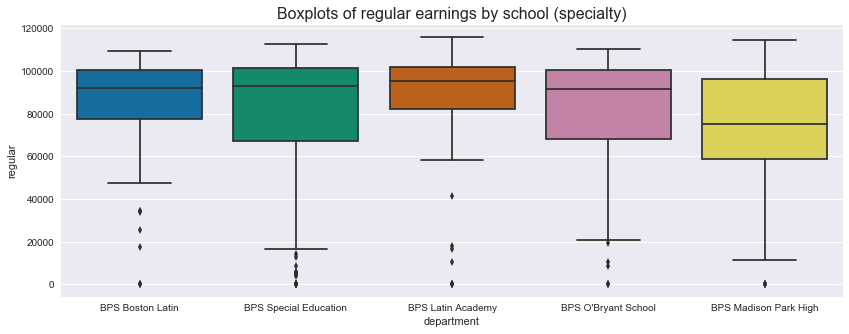

                  sum_sq     df         F    PR(>F)
department  1.660720e+10    4.0  5.076748  0.000488
Residual    5.847319e+11  715.0       NaN       NaN
Effect size: 2.76% of the regular earnings variance is explained by the associated school.


group1,group2,meandiff,lower,upper,reject
BPS Boston Latin,BPS Latin Academy,799.5256,-9804.9991,11404.0502,False
BPS Boston Latin,BPS Madison Park High,-14065.9631,-23885.0923,-4246.8339,True
BPS Boston Latin,BPS O'Bryant School,-5020.1532,-15658.3297,5618.0232,False
BPS Boston Latin,BPS Special Education,-5618.4619,-13892.2448,2655.321,False
BPS Latin Academy,BPS Madison Park High,-14865.4887,-25612.2391,-4118.7382,True
BPS Latin Academy,BPS O'Bryant School,-5819.6788,-17319.5982,5680.2406,False
BPS Latin Academy,BPS Special Education,-6417.9875,-15773.8857,2937.9107,False
BPS Madison Park High,BPS O'Bryant School,9045.8099,-1734.1484,19825.7682,False
BPS Madison Park High,BPS Special Education,8447.5012,-7.804,16902.8064,False
BPS O'Bryant School,BPS Special Education,-598.3087,-9992.3326,8795.7153,False


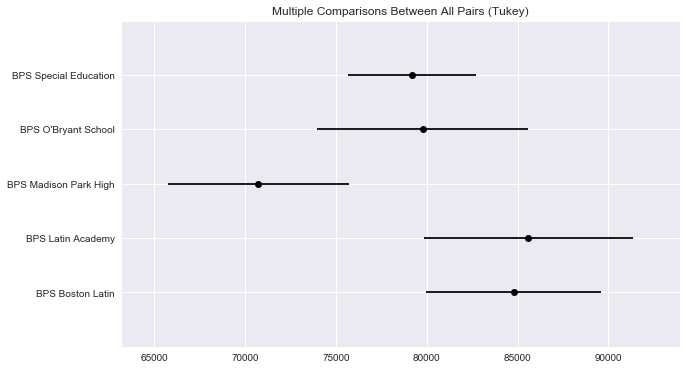

In [8]:
""" ANOVA analysis of regular earnings by specialty school"""

# Only specialty schools:
schools_ref = schools[schools['department'].isin(specialty_schools)]

# Box plot:
fig, ax = plt.subplots(figsize=(14,5))
sns.boxplot(x='department', y='regular', data=schools_ref, ax=ax)
ax.set_title('Boxplots of regular earnings by school (specialty)', fontsize=16)
plt.xticks(rotation=0)
plt.show()

# OLS model:
model = ols('regular ~ department', data=schools_ref).fit()

# ANOVA:                
aov_table = anova_lm(model, typ=2)
print(aov_table)

# effect size
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print('Effect size: {:.2f}% of the regular earnings variance is explained by the associated school.'.format(esq_sm*100))

# Tukey's comparison:
tukey = pairwise_tukeyhsd(endog=schools_ref['regular'],     # Data
                          groups=schools_ref['department'],   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals

tukey.summary()              # See test summary

ANOVA results show that only the vocational school ***BPS Madison Park High*** has a statistically different regular earnings mean compared to the other specialty schools.

### Summary

In summary, the results show that teacher earnings are independent of the school for most schools. The schools that differ from this general rule are specialty schools. The often higher mean regular earnings are probably a result of low turnover. It is possible that an "apples to apples" comparison of teacher pay shows no difference if corrected for turnover, but this cannot be inferred from the data without additional information. Only two specialty schools have a higher variance. The reasons for this are not clear. We can speculate that BPS Mckinley Middle, with its focus on troubled youth, could be a stepping stone into other Boston Public Schools teaching jobs.